In [1]:
# %load ../start.py
# Imports
import os
import sys
from pathlib import Path
import string
import warnings
warnings.filterwarnings('ignore')

import numpy as np
import pandas as pd

import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

# Project level imports
sys.path.insert(0, '../lib')
from larval_gonad.notebook import Nb
from larval_gonad.plotting import make_figs, TSNEPlot

# Setup notebook
nbconfig = Nb.setup_notebook('testis_pilog_scRNAseq_analysis')

# Turn on cache
from joblib import Memory
memory = Memory(cachedir=nbconfig.cache, verbose=0)

%reload_ext rpy2.ipython

last updated: 2017-12-05 
Git hash: 0585cdd8da340735df5064296121559fb4efbbfd


In [2]:
REF = os.environ['REFERENCES_DIR']

In [3]:
%%R -i REF -o OUTPUT
# Import R libraries
.libPaths("/data/fearjm/miniconda3/envs/larval_gonad/lib/R/library")
library(Seurat)
library(dplyr)
library(Matrix)

OUTPUT = '../output/testes_scRNAseq_pilot'
dir.create(OUTPUT, showWarnings=FALSE)

In [4]:
%%R -o meta_data
# Load the testis dataset
testis.data = Read10X(data.dir="../output/testis1/outs/filtered_gene_bc_matrices/dm6.16")

# Initialize the Seurat object with the raw (non-normalized data).
# Keep all genes expressed in >= 3 cells (~0.1% of the data). Keep all cells with at least 200 detected genes
testis = CreateSeuratObject(raw.data = testis.data, min.cells = 3, min.genes = 200, project = "10X_testis")
nCells = dim(testis@meta.data)[1]
meta_data = as.data.frame(testis@meta.data)

write.table(meta_data,
            file=file.path(OUTPUT, 'metadata.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(as.data.frame(as.matrix(testis@raw.data)),
            file=file.path(OUTPUT, 'raw.tsv'),
            quote=FALSE, sep='\t', row.names=TRUE, col.names=TRUE)

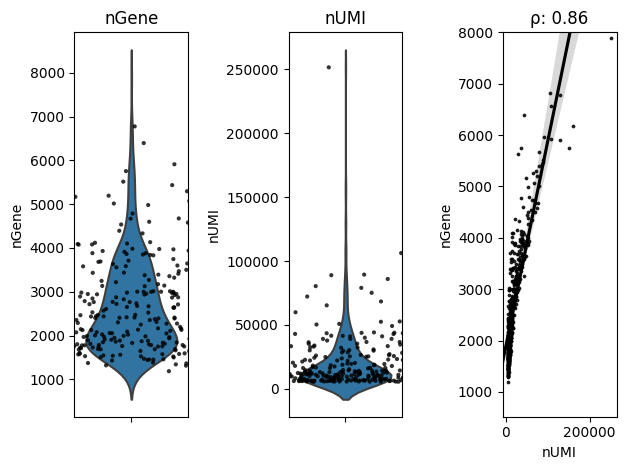

In [5]:
# Plot distribution of gene counts and UMI counts
@make_figs(nbconfig.fig_name('nGene_nUMI_panel'),
           styles=nbconfig.styles_wide, formats=nbconfig.formats)
def plot_nGene_nUMI_panel():
    fig, (ax1, ax2, ax3) = plt.subplots(1, 3)
    
    sns.violinplot(y=meta_data.nGene, ax=ax1, inner=None)
    sns.stripplot(y=meta_data.nGene, color='k', ax=ax1, jitter=1.02, size=3, alpha=.8)
    
    sns.violinplot(y=meta_data.nUMI, ax=ax2, inner=None)
    sns.stripplot(y=meta_data.nUMI, ax=ax2, color='k', jitter=1.02, size=3, alpha=.8)
    
    sns.regplot('nUMI', 'nGene', meta_data, color='k', ax=ax3, scatter_kws={'s': 3})

    ax1.set_title('nGene')
    ax2.set_title('nUMI')
    
    rho = np.round(stats.pearsonr(meta_data.nGene, meta_data.nUMI)[0], 2)
    ax3.set_title(f'ρ: {rho}')
    ax3.set_ylim(None, 8000)
    plt.tight_layout()
    
plot_nGene_nUMI_panel()

In [6]:
%%R -o dispersion -o norm
testis = FilterCells(object=testis, subset.names=c("nGene"), 
                     low.thresholds=c(200), high.thresholds=c(6000))

testis = NormalizeData(object=testis, normalization.method="LogNormalize", 
                       scale.factor=1e4)

### Detection of variable genes across the single cells
testis = FindVariableGenes(object=testis, 
                           mean.function=ExpMean, 
                           dispersion.function=LogVMR, 
                           x.low.cutoff=0.01, 
                           x.high.cutoff=3, 
                           y.cutoff=0.5,
                           y.high.cutoff=Inf,
                           do.plot=FALSE
                          )

norm = as.data.frame(as.matrix(testis@data))

write.table(norm,
            file=file.path(OUTPUT, 'normalized_read_counts.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

dispersion = as.data.frame(as.matrix(testis@hvg.info))

write.table(dispersion,
            file=file.path(OUTPUT, 'dispersion.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)


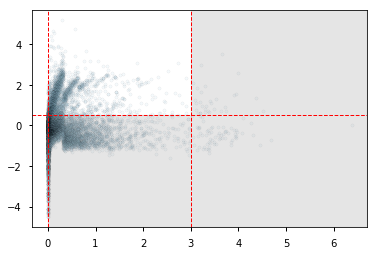

In [7]:
def plot_dispersion():
    _x_low = 0.01
    _x_high = 3
    _y_low = 0.5

    fig, ax = plt.subplots(1, 1)
    ax.scatter(dispersion['gene.mean'], dispersion['gene.dispersion.scaled'], 
                s=10, alpha=.1, edgecolor='k')
    ax.axvline(_x_low, ls='--', lw=1, color='r')
    ax.axvline(_x_high, ls='--', lw=1, color='r')
    ax.axhline(_y_low, ls='--', lw=1, color='r')

    _x_min, _x_max = ax.get_xlim()
    _y_min, _y_max = ax.get_ylim()

    verts = [
        [_x_low, _y_min], 
        [_x_low, _y_low], 
        [_x_high, _y_low], 
        [_x_high, _y_max],
        [_x_max, _y_max],
        [_x_max, _y_min],
    ]
    p1 = mpl.patches.Polygon(verts, color='grey', alpha=.2)
    ax.add_patch(p1)
    
plot_dispersion()

In [8]:
%%R -o pca_res -o gene_loadings
print(length(x=testis@var.genes))

### Scaling the data and removing unwanted sources of variation
testis = ScaleData(object=testis, vars.to.regress=c("nUMI"),
                  display.progress=FALSE)

### Perform linear dimensional reduction
testis = RunPCA(object=testis, pc.genes=testis@var.genes, do.print=TRUE, 
                pcs.print=1:5, genes.print=5, pcs.compute=100)

# ProjectPCA scores each gene in the dataset (including genes not included in the PCA) based on their correlation
# with the calculated components. Though we don't use this further here, it can be used to identify markers that
# are strongly correlated with cellular heterogeneity, but may not have passed through variable gene selection.
# The results of the projected PCA can be explored by setting use.full=T in the functions above
testis = ProjectPCA(object=testis, do.print=FALSE)

pca_res = as.data.frame(testis@dr$pca@cell.embeddings)
gene_loadings = as.data.frame(testis@dr$pca@gene.loadings)

write.table(pca_res,
            file=file.path(OUTPUT, 'principal_components_cell.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(gene_loadings,
            file=file.path(OUTPUT, 'principal_components_gene.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

write.table(as.data.frame(testis@scale.data),
            file=file.path(OUTPUT, 'scaled.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

[1] 2588
[1] "PC1"
[1] "FBgn0051909" "FBgn0264543" "FBgn0033020" "FBgn0265648" "FBgn0038225"
[1] ""
[1] "FBgn0000042" "FBgn0031453" "FBgn0026084" "FBgn0010113" "FBgn0262160"
[1] ""
[1] ""
[1] "PC2"
[1] "FBgn0261260" "FBgn0259740" "FBgn0085446" "FBgn0002921" "FBgn0043841"
[1] ""
[1] "FBgn0031296" "FBgn0030629" "FBgn0036809" "FBgn0034822" "FBgn0035608"
[1] ""
[1] ""
[1] "PC3"
[1] "FBgn0034245" "FBgn0031830" "FBgn0263415" "FBgn0063494" "FBgn0030409"
[1] ""
[1] "FBgn0283451" "FBgn0004606" "FBgn0002543" "FBgn0261836" "FBgn0051778"
[1] ""
[1] ""
[1] "PC4"
[1] "FBgn0259244" "FBgn0004795" "FBgn0000015" "FBgn0086408" "FBgn0002592"
[1] ""
[1] "FBgn0085282" "FBgn0053494" "FBgn0031381" "FBgn0041182" "FBgn0000299"
[1] ""
[1] ""
[1] "PC5"
[1] "FBgn0029856" "FBgn0029589" "FBgn0262905" "FBgn0028900" "FBgn0053222"
[1] ""
[1] "FBgn0038191" "FBgn0283442" "FBgn0030667" "FBgn0000146" "FBgn0031074"
[1] ""
[1] ""


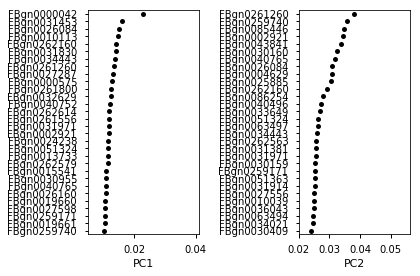

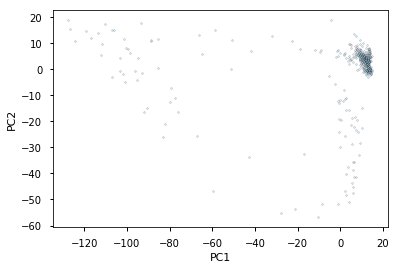

In [9]:
def plot_pca():
    pc1 = gene_loadings.PC1.sort_values(ascending=False).head(30).reset_index()
    pc2 = (gene_loadings.PC2 * -1).sort_values(ascending=False).head(30).reset_index()

    fig, (ax1, ax2) = plt.subplots(1, 2)
    sns.stripplot(x="PC1", y="index", data=pc1, ax=ax1, color='k')
    #ax1.set_xlim(0.0306, 0.0317)
    ax1.set_ylabel('')

    sns.stripplot(x="PC2", y="index", data=pc2, ax=ax2, color='k')
    #ax2.set_xlim(0.063, 0.073)
    ax2.set_ylabel('')
    plt.tight_layout()

    fig, ax = plt.subplots(1, 1)
    ax.scatter(pca_res.PC1, -1 * pca_res.PC2, alpha=.4, s=3, edgecolor='k')
    ax.set_xlabel('PC1')
    ax.set_ylabel('PC2')
    
plot_pca()

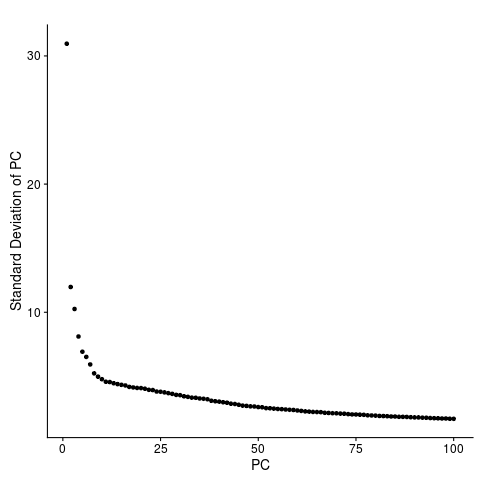

In [10]:
%%R
#PCHeatmap(object=testis, pc.use=1:12, cells.use=500, do.balanced=TRUE, label.columns=FALSE, 
#          use.full=FALSE)

### Determine statistically significant principal components
PCElbowPlot(object=testis, num.pc=100)

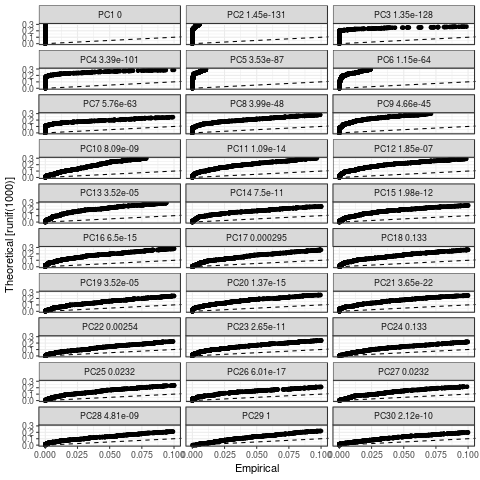

In [11]:
%%R
# NOTE: This process can take a long time for big datasets, comment out for expediency.
# More approximate techniques such as those implemented in PCElbowPlot() can be used to reduce computation time
testis = JackStraw(object=testis, num.replicate=100, do.print=FALSE, num.pc=30)
JackStrawPlot(object=testis, PCs=1:30)

In [12]:
%%R -o ident -o tsne
testis = FindClusters(object=testis, reduction.type="pca", dims.use=1:30, 
                      resolution=0.6, print.output=0, save.SNN=TRUE)

PrintFindClustersParams(object=testis)
# While we do provide function-specific printing functions, the more general function to
# print calculation parameters is PrintCalcParams().

ident = as.data.frame(testis@ident)
colnames(ident) = c('ident')

write.table(ident,
            file=file.path(OUTPUT, 'clusters.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)


### Run Non-linear dimensional reduction (tSNE)
testis = RunTSNE(object=testis, dims.use=1:30, do.fast=TRUE)

tsne = as.data.frame(testis@dr$tsne@cell.embeddings)

write.table(tsne,
            file=file.path(OUTPUT, 'tsne.tsv'),
            quote=FALSE, sep="\t", row.names=TRUE, col.names=TRUE)

# Save 
save(testis, file = file.path(OUTPUT, "seurat.Robj"))

Parameters used in latest FindClusters calculation run on: 2017-12-05 08:45:39
Resolution: 0.6
-----------------------------------------------------------------------------
Modularity Function    Algorithm         n.start         n.iter
     1                   1                 100             10
-----------------------------------------------------------------------------
Reduction used          k.param          k.scale          prune.SNN
     pca                 30                25              0.0667
-----------------------------------------------------------------------------
Dims used in calculation
1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24 25 26 27 28 29
30



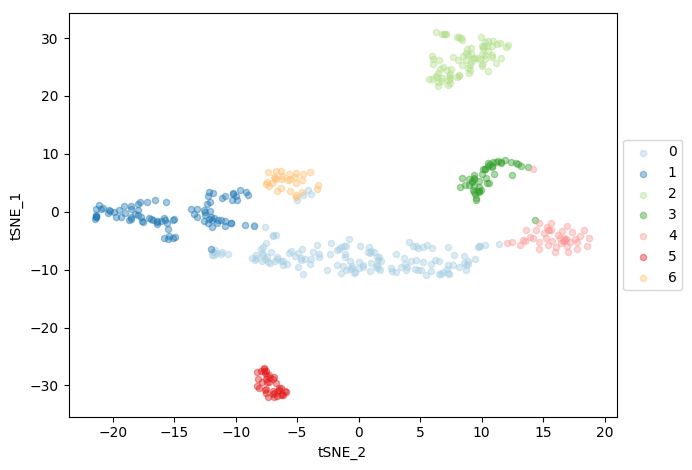

In [13]:
@make_figs(nbconfig.fig_name('tSNE'), nbconfig.styles, nbconfig.formats)
def plot_tSNE():
    _df = tsne.join(ident)
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue='ident', 
                 palette=nbconfig.colors, alpha=.4)
    
plot_tSNE()

In [14]:
%%R -o testis_markers
### Finding differentially expressed genes (cluster biomarkers)
# find markers for every cluster compared to all remaining cells, report only the positive ones
testis_markers = FindAllMarkers(object=testis, only.pos=TRUE, 
                                min.pct=0.25, thresh.use=0.25,
                                print.bar=FALSE)

rownames(testis_markers) = NULL

testis_markers %>% group_by(cluster) %>% top_n(2, avg_logFC)

write.table(testis_markers, 
           file=file.path(OUTPUT, 'biomarkers.tsv'),
           quote=FALSE, sep='\t', row.names=FALSE, col.names=TRUE)

In [15]:
# Create fbgn2symbol 
annot = pd.read_csv(Path(REF, 'dmel/r6-16/fb_annotation/dmel_r6-16.fb_annotation'),
                   sep='\t', index_col=1)

fbgn2symbol = annot['gene_symbol'].to_dict()

In [16]:
def plot_gene(symbol=None, fbgn=None, **kwargs):
    if symbol is None:
        symbol = fbgn2symbol[fbgn]

    if fbgn is None:
        fbgn = symbol2fbgn[symbol]

    fig, (ax1, ax2) = plt.subplots(1, 2, gridspec_kw={'width_ratios': [1.2, 1]})
    _df = tsne.join(norm.T.copy()[fbgn])
    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=fbgn, s=10, 
             ax=ax1, title='Normalized Expression\n(Continuous)', **kwargs)

    TSNEPlot('tSNE_2', 'tSNE_1', data=_df, hue=_df[fbgn] > 0, 
             cmap={
                 '0': 'w',
                 '1': 'k',
             }, s=10, ax=ax2, alpha=.6, edgecolor='k', title='Normalized Expression\n(Binary)', **kwargs)

    fig.suptitle(f'{symbol} ({fbgn})');

    
@make_figs(nbconfig.fig_name('gene_tSNE'), nbconfig.styles_wide, 
           nbconfig.formats, kws_layout={'w_pad': 1, 'rect': [0, 0, .9, .9]})
def _plot_gene(*args, **kwargs):
    plot_gene(*args, **kwargs)
    

In [ ]:
def iter_plot(fbgns, pth=Path('../output/figures/testis_pilot_tsne')):
    pth.mkdir(exist_ok=True)
    
    if isinstance(fbgns, str):
        fbgns = [fbgns]
    
    def sanitize_fname(fname):
        valid_chars = "-_.%s%s" % (string.ascii_letters, string.digits)
        return ''.join([x for x in fname if x in valid_chars])

    for fbgn in fbgns:
        gene = fbgn2symbol[fbgn]
        _gene = sanitize_fname(gene)
        fname = f'{_gene}_{fbgn}'
        
        if (pth / (fname + '_paper-wide.png')).exists() & (pth / (fname + '_paper-wide.png')).exists() & \
           (pth / (fname + '_talk-wide.png')).exists() & (pth / (fname + '_talk-wide.png')).exists() :
            continue
        
        @make_figs(str(pth / fname), ['talk-wide', 'paper-wide'], 
                   ['png', 'pdf'], kws_layout={'w_pad': 1, 'rect': [0, 0, .9, .95]})
        def _plot_gene(*args, **kwargs):
            plot_gene(*args, **kwargs)
            
        _plot_gene(symbol=gene, fbgn=fbgn)
        plt.close()
        

In [ ]:
iter_plot(testis_markers.gene.unique().tolist())

In [ ]:
print('yes')